In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram

Generation of the covariance matrix and normalization

In [18]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)

covmat = np.dot(centered.transpose(),centered)
covmat=covmat/np.trace(covmat)
print(covmat)
eigval, eigvec = np.linalg.eig(covmat)
print("Eigenvalues: ")
print(eigval)
print("Eigenvectors: ")
print(eigvec)

[[ 0.33357937  0.08967467 -0.03323781  0.06170738]
 [ 0.08967467  0.17091269  0.08103015  0.02002656]
 [-0.03323781  0.08103015  0.23928192  0.11411546]
 [ 0.06170738  0.02002656  0.11411546  0.25622602]]
Eigenvalues: 
[0.42349093 0.3361911  0.05677389 0.18354408]
Eigenvectors: 
[[ 0.61977545  0.69639438 -0.35705775  0.05850655]
 [ 0.39215791  0.02847075  0.62586034 -0.67357288]
 [ 0.40080051 -0.6262992  -0.58025751 -0.33227923]
 [ 0.54904418 -0.34924718  0.379618    0.65762229]]


In [22]:
bits = 3
#initial =[ 0.28526355, -0.14474718, -0.02720251,  0.03417223]
initial = [ 0.53458358, -0.22015499 ,-0.70077363, -0.4179336 ]
res=qpca(covmat,bits,initialeig= initial ,iterations=1)

print(res.get_eigvals())

first_approx [ 0.53458358 -0.22015499 -0.70077363 -0.4179336 ]
last_approx [ 0.53458358 -0.22015499 -0.70077363 -0.4179336 ]
{0.375: 8569, 0.625: 257, 0.5: 692, 0.25: 1793, 0.0: 216, 0.75: 149, 0.125: 474, 0.875: 138}
[(0.875, 138), (0.75, 149), (0.0, 216), (0.625, 257), (0.125, 474), (0.5, 692), (0.25, 1793), (0.375, 8569)]


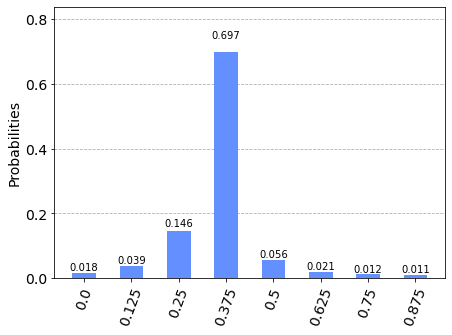

In [23]:
plot_histogram(res.get_eigvals(False))

In [24]:
eigval_to_find = 0.375
eigv = res.eigvec_from_eigval(eigval_to_find)
print(eigv)

[[ 0.74605662 -0.09875576 -0.59429542 -0.28365431]]
